# **DEEP LEARNING MODEL USING LSTM TO PREDICT FAKE NEWS**

**IMPORTING LIBRARIES**

In [ ]:
import re
import os
import urllib
import pandas as pd
import numpy as np
import nltk
import keras
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, LSTM, Embedding, Reshape
from keras.models import load_model, model_from_json
from sklearn.model_selection import train_test_split
from urllib.request import urlretrieve
from os import mkdir, makedirs, remove, listdir
from collections import Counter

Using TensorFlow backend.


**LOAD DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Projects - Hackathon/FakeNews Detection/Fake_or_real_news.csv', usecols=["title","text","label"]) 
#df = pd.read_csv('/content/drive/My Drive/FakeNews Detection/fake_or_real_news.csv')
df.head()

,title,text,label
0,You Can Smell Hillarys Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51652 entries, 0 to 52785
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   51652 non-null  object
 1   text    51652 non-null  object
 2   label   51652 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


**CHECK NULL VALUES**

In [ ]:
df.duplicated().sum()
df.drop_duplicates(inplace=True)
df

In [ ]:
df.isna().sum()

title     682
text      917
label    1133
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [ ]:
x = df['title'] + "" + df['text']
y = pd.get_dummies(df['label'])
y = np.array(y)

In [ ]:
x[0]

'you can smell hillarys feardaniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam . in the final stretch of the election hillary rodham clinton has gone to war with the fbi . the word unprecedented has been thrown around so often this election that it ought to be retired . but its still unprecedented for the nominee of a major political party to go war with the fbi . but thats exactly what hillary and her people have done . coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillarys opponent in this election . the fbi is under attack by everyone from obama to cnn . hillarys people have circulated a letter attacking comey . there are currently more media hit pieces lambasting him than targeting trump . it wouldnt be too surprising if the clintons or their allies were to start running attack ads against the fbi . the fbis leadership is being warne

In [ ]:
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
y = pd.get_dummies(df['label'])

In [ ]:
y.head()

,1948. [57],200 million microwave ovens,21 Oct. 2015. Web. 3 Aug. 2016. http://www.nytimes.com/2015/10/22/science/quantum-theory-experiment-said-to-prove-spooky-interactions.html?_r=0,Adivasis,Afghanistan and Iraq. I do not think that we have the luxury of time. Time is not on our side. Let’s pull together before it is too late,American aircraft carried out a strike against Syrian troops,Arab villages were henceforward to be leveled to prevent their reinvestment by Arab forces; the implication was that their inhabitants were to be expelled and prevented from returning.” [87] The Haganah “embarked on a campaign of clearing areas of Arab inhabitants and militia forces and conquering and leveling villages”. [88] Plan D implemented a “new policy,Aryan invaders who want to oppress the indigenous black-skinned Indians; they are the educated elites and their croneys from all castes and classes regard the workers and peasants simply as vote banks and as the labour resource to be used and thrown. BJP,Australia). ((Socialism tends to do better when there is money in the ground. Think Norway,Ben Plesser,Beyond Coal has more than 100 legal cases pending over power supply. Meanwhile,Bill Cosby’s serial predations had just exploded into the news after laying dormant for many years. Bannon was certain this signaled trouble for Bill Clinton,Brighton and the small village of Parc in France (where family legend has it we got our name from Charlemagne himself). But my family and I have no choice but to stay put.,CPI(M) and CPI (ML) and CPI have to be concentrated there.,Cabinet officials,China,Denmark passed what became known as the “ jewellery law ”,Duncan explained “Baiame came from a place that we call the Morning Star within the Mirrabooka. Mira means stars and booka means river. That is the Milky Way that flows across the North Star. ”43 Baiame,Fla. Biden stumps for Clinton in Dayton and Toledo,"Francis also said he's concerned about """"the family",GOD I hate what we have become),George W. Bush,God promised it to us,Haganah policy was purely defensive”,Hillary has not confessed,Hugh Naylor writes. And the impending assault represents an “intensified international effort” to increase pressure on the extremist group as it loses control of territory in the countries.,I agree,I am not rich. Wherever you think is viable,I can’t live in a country that looks the other way when a candidate is a sexist,I decided to agree with the American proposal at the talks. They were persistent and I decided to accept a compromise,I have found nothing other than often powerful statements of commitment to our nation,I really don’t have anyone to welcome me in another country,I was brought to the US when I was 13y/o and since then I have always dreamed of leaving this place. Trying to pick a career was very difficult because I also didn’t want to pay 100k on a degree here to move to another country and make significantly less,I was the only one to do so. The situation is strange; it is the only issue on which I agree with Mr Poroshenko. I have spoken about this more than once; there is nothing new here. Ultimately,I.e. Real Estate. Commodities and Industry,Israel Galili “ordered all the Haganah brigades not to uproot Arabs from the territory of the designated Jewish state.” In 1948,Ive been-a supporter.,Japanese,King of the Crimean Scythians,Morris notes). In charge of these operations was the commander of the Palmach,...,who will call the shots. World War 3 is a real distinct possibility with this charlatan in the Oval Office. Would anybody care to wager on another false flag event similar if not worse to 9-11 to further an agenda? This time,whose language I speak,whose plan left more than 400,will be,will pay about ~$1.4k per month over 25 years @ 7% pa. Were the borrower asked to repay the entire sum TODAY does that mean the borrower is insolvent? No. The borrower has 25 years of income,you are very lucky. What Freedoms and Liberties Will You Lose By Moving? 

**USING GLOVE VECTORS TO CONVERT WORDS TO NUM**

In [ ]:
with open('/content/drive/My Drive/Projects - Hackathon/FakeNews Detection/glove.6B.50d.txt','rb') as f:
    lines = f.readlines()
    
glove_weights = np.zeros((len(lines), 50))
words = []
for i, line in enumerate(lines):
    word_weights = line.split()
    words.append(word_weights[0])
    weight = word_weights[1:]
    glove_weights[i] = np.array([float(w) for w in weight])
word_vocab = [w.decode("utf-8") for w in words]

word2glove = dict(zip(word_vocab, glove_weights))

In [ ]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
GLOVE_DIR = 'glove.6B.100d.txt'

**DATA CLEANING**

In [ ]:
#df.drop('Unnamed: 0', axis=1, inplace=True)
df.title = df.title.str.lower()
df.text = df.text.str.lower()
df.title = df.title.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.text = df.text.str.replace(r'http[\w:/\.]+','<URL>') # remove urls
df.title = df.title.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.text = df.text.str.replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
df.title = df.title.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.text = df.text.str.replace(r'\.\.+','.') #replace multple periods with a single one
df.title = df.title.str.replace(r'\.',' . ') #replace periods with a single one
df.text = df.text.str.replace(r'\.',' . ') #replace multple periods with a single one
df.title = df.title.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.text = df.text.str.replace(r'\s\s+',' ') #replace multple white space with a single one
df.title = df.title.str.strip() 
df.text = df.text.str.strip() 
print(df.shape)
df.head()

(51652, 3)


,title,text,label
0,you can smell hillarys fear,daniel greenfield a shillman journalism fellow...,FAKE
1,watch the exact moment paul ryan committed pol...,google pinterest digg linkedin reddit stumbleu...,FAKE
2,kerry to go to paris in gesture of sympathy,u . s . secretary of state john f . kerry said...,REAL
3,bernie supporters on twitter erupt in anger ag...,kaydee king kaydeeking november 9 2016 the les...,FAKE
4,the battle of new york why this primary matters,its primary day in new york and frontrunners h...,REAL


In [ ]:
from tqdm.notebook import tqdm
from tqdm import tqdm_notebook
from ipywidgets import IntProgress
from collections import Counter

In [ ]:
all_text = ' '.join(df.text.values)
words = all_text.split()
u_words = Counter(words).most_common()
u_words_counter = u_words
u_words_frequent = [word[0] for word in u_words if word[1]>5] # we will only consider words that have been used more than 5 times

u_words_total = [k for k,v in u_words_counter]
word_vocab = dict(zip(word_vocab, range(len(word_vocab))))
word_in_glove = np.array([w in word_vocab for w in u_words_total])

words_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if is_true]
words_not_in_glove = [w for w,is_true in zip(u_words_total,word_in_glove) if not is_true]

print('Fraction of unique words in glove vectors: ', sum(word_in_glove)/len(word_in_glove))

# # create the dictionary
word2num = dict(zip(words_in_glove,range(len(words_in_glove))))
len_glove_words = len(word2num)
freq_words_not_glove = [w for w in words_not_in_glove if w in u_words_frequent]
b = dict(zip(freq_words_not_glove,range(len(word2num), len(word2num)+len(freq_words_not_glove))))
word2num = dict(**word2num, **b)
word2num['<Other>'] = len(word2num)
num2word = dict(zip(word2num.values(), word2num.keys()))

int_text = [[word2num[word] if word in word2num else word2num['<Other>'] 
             for word in content.split()] for content in df.text.values]

print('The number of unique words are: ', len(u_words))
print('The first review looks like this: ')
print(int_text[0][:20])
print('And once this is converted back to words, it looks like: ')
print(' '.join([num2word[i] for i in int_text[0][:20]]))

Fraction of unique words in glove vectors:  0.46208299599344005
The number of unique words are:  192684
The first review looks like this: 
[3663, 15048, 5, 93440, 3733, 1127, 28, 0, 730, 566, 10, 5, 61, 226, 3337, 3366, 8, 1324, 1602, 1]
And once this is converted back to words, it looks like: 
daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam .


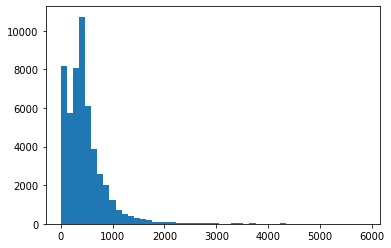

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(t) for t in int_text],50)
plt.show()

In [ ]:
print('The number of articles greater than 500 in length is: ', np.sum(np.array([len(t)>500 for t in int_text])))
print('The number of articles less than 50 in length is: ', np.sum(np.array([len(t)<50 for t in int_text])))

The number of articles greater than 500 in length is:  17016
The number of articles less than 50 in length is:  2996


In [ ]:
word2num['<PAD>'] = len(word2num)

for i, t in enumerate(int_text):
    if len(t)<500:
        int_text[i] = [word2num['<PAD>']]*(500-len(t)) + t
    elif len(t)>500:
        int_text[i] = t[:500]
    else:
        continue

x = np.array(int_text)
y = (df.label.values=='REAL').astype('int')
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
df[df.label=='REAL'].text.values[0]

'u . s . secretary of state john f . kerry said monday that he will stop in paris later this week amid criticism that no top american officials attended sundays unity march against terrorism . kerry said he expects to arrive in paris thursday evening as he heads home after a week abroad . he said he will fly to france at the conclusion of a series of meetings scheduled for thursday in sofia bulgaria . he plans to meet the next day with foreign minister laurent fabius and president francois hollande then return to washington . the visit by kerry who has family and childhood ties to the country and speaks fluent french could address some of the criticism that the united states snubbed france in its darkest hour in many years . the french press on monday was filled with questions about why neither president obama nor kerry attended sundays march as about 40 leaders of other nations did . obama was said to have stayed away because his own security needs can be taxing on a country and kerry

In [ ]:
df[df.label=='FAKE'].text.values[0]

'daniel greenfield a shillman journalism fellow at the freedom center is a new york writer focusing on radical islam . in the final stretch of the election hillary rodham clinton has gone to war with the fbi . the word unprecedented has been thrown around so often this election that it ought to be retired . but its still unprecedented for the nominee of a major political party to go war with the fbi . but thats exactly what hillary and her people have done . coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillarys opponent in this election . the fbi is under attack by everyone from obama to cnn . hillarys people have circulated a letter attacking comey . there are currently more media hit pieces lambasting him than targeting trump . it wouldnt be too surprising if the clintons or their allies were to start running attack ads against the fbi . the fbis leadership is being warned that the entire leftwing 

**TRAIN LSTM MODEL**

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(len(word2num), 50))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          4854200   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 128)         91648     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,997,369
Trainable params: 4,997,369
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

In [ ]:
model.fit(X_train, y_train, batch_size=128, epochs=8, validation_data=(X_test, y_test),callbacks = [learning_rate_reduction])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 41321 samples, validate on 10331 samples
Epoch 1/8
41321/41321 [==============================] - 1232s 30ms/step - loss: 0.2935 - accuracy: 0.8688 - val_loss: 0.0923 - val_accuracy: 0.9610
Epoch 2/8
41321/41321 [==============================] - 1228s 30ms/step - loss: 0.0717 - accuracy: 0.9727 - val_loss: 0.0498 - val_accuracy: 0.9828
Epoch 3/8
41321/41321 [==============================] - 1189s 29ms/step - loss: 0.0283 - accuracy: 0.9901 - val_loss: 0.0456 - val_accuracy: 0.9828
Epoch 4/8
41321/41321 [==============================] - 1205s 29ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.0430 - val_accuracy: 0.9853
Epoch 5/8
41321/41321 [==============================] - 1206s 29ms/step - loss: 0.0111 - accuracy: 0.9966 - val_loss: 0.0534 - val_accuracy: 0.9854
Epoch 6/8
41321/41321 [==============================] - 1228s 30ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.0426 - val_accuracy: 0.9877
Epoch 7/8
41321/41321 [==============================] -

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
#model.save_weights('model')

**CHECK RESULTS**

In [ ]:
sentence = "North korea is testing out missiles on americans living overseas .".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

In [ ]:
sentence = "The chemicals in the water is turning the freaking frogs gay says cnn . ".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(500-len(sentence_num)) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

In [ ]:
#Have we finally reached a moment of promise and possibility on race? - real(P:fake)
#5 ways racism is bad for business – and what we can do about it - real(P:real)
#'We existed in parallel universes’ – what it’s like to be black in Silicon Valley - real(P:fake)
#The Forum’s COVID Action Platform: Over 1,000 organizations are working together in response to the pandemic - real(P:fake)
sentence = "The Forum’s COVID Action Platform: Over 1,000 organizations are working together in response to the pandemic".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(0) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

In [ ]:
sentence = "The most exceedingly terrible of the pandemic is yet to come. Until this point in time, just a couple of nations are successfully containing the infection, while in a dominant part of countries, COVID-19 is either seething or reemerging with neighborhood episodes, restricted or not really. As of now, in scarcely a half year, the COVID-19 pandemic has plunged our reality completely - and every one of us independently - into the most testing occasions we've looked in ages. It is a pivotal turning point – we will manage its aftermath for a considerable length of time, and numerous things will change until the end of time. It has fashioned (and will keep on doing as such) financial interruption of stupendous extents, making danger and unpredictability on numerous fronts – political, social, international – while compounding profound worries about the earth and furthermore broadening the span (poisonous or something else) of innovation into our lives.".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(0) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

In [ ]:
sentence = "Kerry to go to Paris in gesture of sympathy".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(0) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

In [ ]:
sentence = "The worst of the pandemic is yet to come. To date, only a few countries are effectively containing the virus, while in a majority of nations, COVID-19 is either raging or resurfacing with local outbreaks, limited or not so.Already, in barely six months, the COVID-19 pandemic has plunged our world in its entirety - and each of us individually - into the most challenging times we’ve faced in generations. It is a defining moment – we will be dealing with its fallout for years, and many things will change forever. It has wrought (and will continue to do so) economic disruption of monumental proportions, creating risk and volatility on multiple fronts – political, social, geopolitical – while exacerbating deep concerns about the environment and also extending the reach (pernicious or otherwise) of technology into our lives.".lower()
sentence_num = [word2num[w] if w in word2num else word2num['<Other>'] for w in sentence.split()]
sentence_num = [word2num['<PAD>']]*(0) + sentence_num
sentence_num = np.array(sentence_num)
model.predict(sentence_num[None,:])

**SAVE MODEL**

In [ ]:
import pickle
pickle.dump( model, open( "model_lstm.pkl", "wb" ) )